# Statistik und fehlende Werte
Mit realen Datensätzen entsteht häufig die Problematik, dass Daten fehlen oder implizite Werte haben. In dieser Übung sollen Sie für einen Datensatz aus dem US-Zensus die Einkommensungleichheit berechnen und visualisieren.

Lesen Sie dazu zunächst die Einkommen aus dem US-Zensusdatensatz von 2017 ein:

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

import pathlib
import urllib.request

## <span style="color:red">ACHTUNG:</span> Die Datei 'US_ACS_2017_10pct_sample.dta' nicht mit in der Lösung hochladen.

In [110]:
url = 'https://github.com/nickeubank/MIDS_Data/raw/master/US_AmericanCommunitySurvey/US_ACS_2017_10pct_sample.dta'
data_file = pathlib.Path(url.rsplit('/', 1)[-1])

if not data_file.is_file():
    # this downloads 63 MB of data. May take a few seconds.
    # We could also use `census_data = pd.read_stata(url)['inctot']`
    # but here we save the file to disk in case we need to reset it.
    urllib.request.urlretrieve(url, data_file)

census_data = pd.read_stata(data_file.resolve())['inctot']

## Bereinigung von Daten

**[1P]** Berechnen Sie grundlegende statistische Indikatoren für Ihre Daten. Fällt Ihnen etwas auf? Nutzen Sie ggf. auch die Ergebnisse Ihrer Plots unten oder die Ergebnisse der Methode `Series.value_counts`.

In [111]:
census_data.describe()


count    3.190040e+05
mean     1.723646e+06
std      3.732326e+06
min     -9.000000e+03
25%      1.050000e+04
50%      3.370000e+04
75%      9.140000e+04
max      9.999999e+06
Name: inctot, dtype: float64

**\[2 Pt\]** Die `Series` enthält eine ganze Menge an offensichtlich falschen Werten. Wie können Sie fehlende und offensichtlich falsche Werte ersetzen? Ersinnen Sie zwei unterschiedliche Strategien und setzen Sie diese um.

In [120]:
census_data_edit_1 = census_data.loc[(census_data >= 0) & (census_data < 9999999)].copy()
census_data_edit_2 = census_data.loc[(census_data < 9999999)].copy()
census_data_edit_2[census_data_edit_2 < 0] = 0
census_data_edit_1.reset_index(drop=True, inplace=True)#
census_data_edit_2.reset_index(drop=True, inplace=True)#

print(census_data_edit_1.describe())
census_data_edit_2.sort_index().head(10)


count    2.647930e+05
mean     4.094132e+04
std      6.136586e+04
min      0.000000e+00
25%      8.060000e+03
50%      2.460000e+04
75%      5.100000e+04
max      1.563000e+06
Name: inctot, dtype: float64


0     6000
1     6150
2    14000
3    50000
4    27100
5     2000
6    18000
7    24000
8        0
9        0
Name: inctot, dtype: int32

**\[2 Pt\]** Erstellen Sie eine sinnvolle Abbildung der Einkommensverteilung. Nutzen Sie eine von ihnen gewählte Strategie zur Ersetzung von falschen/fehlenden Werten.

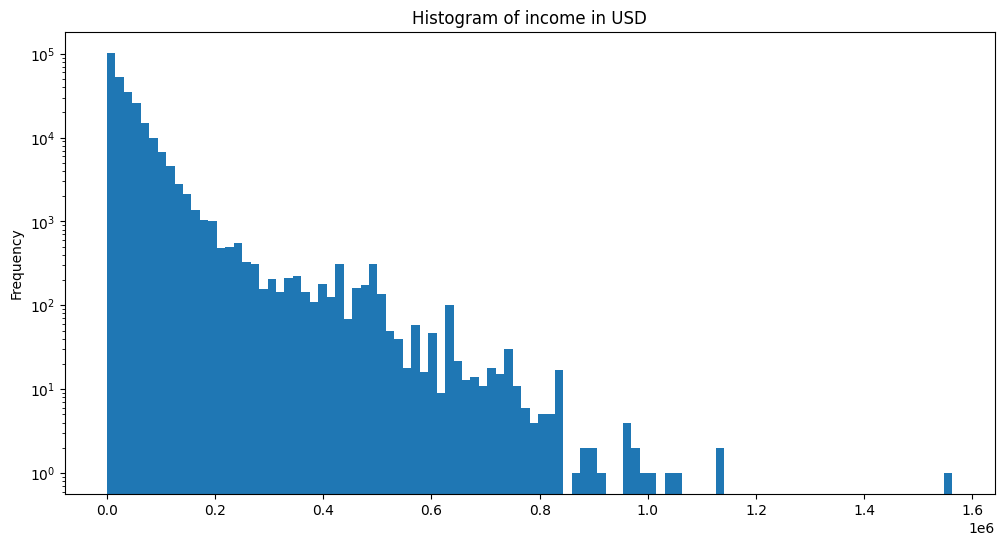

In [121]:
def visualize_data(data: pd.Series):
    data.plot(kind='hist', 
              bins=100, 
              figsize=(12, 6),
              title='Histogram of income in USD',
              logy=True,
                )
    
visualize_data(census_data_edit_1)

## Einkommensungleichheit

### Die Lorenz-Kurve
Um die Ungleichheit der Einkommen zu visualisieren, bietet sich die sogenannte Lorenz-Kurve an. Hierbei werden die Werte zunächst sortiert und dann die kumulierte statistische Größe gegen den kumulierten Populationsanteil aufgetragen.

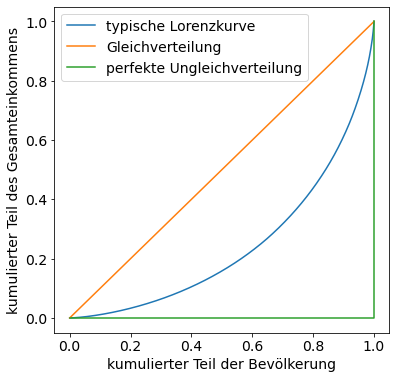

**\[3 Pt\]** 
Verarbeiten Sie Ihre Daten so, dass sie einen entsprechenden Plot erzeugen können. Stellen Sie die kumulierte Einkommensverteilung (kumuliertes Einkommen gegen kumulierter Anteil der Bevölkerung) im Stile einer Lorenz-Kurve dar. Stellen Sie außerdem zum Vergleich eine perfekt ausgeglichene  und eine perfekt unausgeglichene Einkommensverteilung dar.

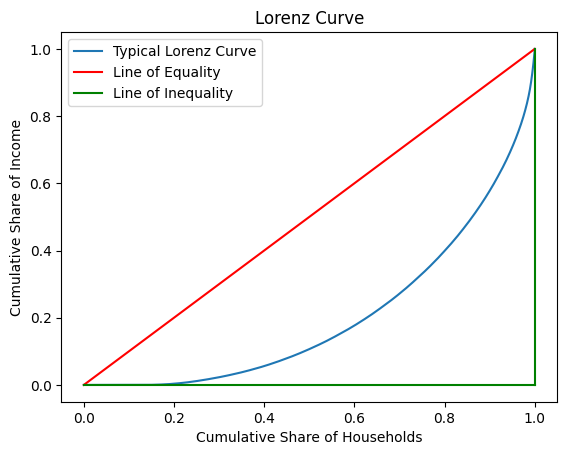

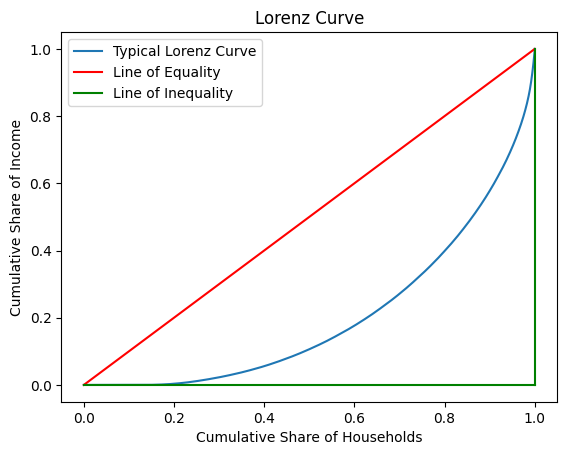

In [122]:
def typical_lorenz_curve(data: pd.Series):
    typical_lorenz = data.sort_values().cumsum() / data.sum()
    plt.plot(np.linspace(0, 1, len(typical_lorenz)), typical_lorenz, label='Typical Lorenz Curve')
    plt.plot([0, 1], [0, 1], color='red', label='Line of Equality')
    plt.plot([1, 1], [0, 1], color='green', label='Line of Inequality')
    plt.plot([0, 1], [0, 0], color='green')
    plt.xlabel('Cumulative Share of Households')
    plt.ylabel('Cumulative Share of Income')
    plt.title('Lorenz Curve')
    plt.legend()
    plt.show()

typical_lorenz_curve(census_data_edit_1)
typical_lorenz_curve(census_data_edit_2)

### Der Gini-Koeffizient
Der Gini-Koeffizient ist ein statistisches Maß für die ungleiche Verteilung einer nichtnegativen Größe. Er wird häufig verwendet, um Einkommens- oder Vermögensungleichheit in einer Gesellschaft oder zwischen Staaten zu quantifizieren.

Für eine Reihe diskreter Werte $y_i$ (mit $1 \le i \le N$), die in monoton steigender Reihenfolge vorliegen ($y_i \le y_{i+1}$), ist der Gini-Koeffizient definiert als
$$ G = 2 \frac{\sum_{i=1}^n i \cdot y_i }{n \sum_{i=1}^n y_i} − \frac{n+1}{n}$$

3. **\[3 Pt\]**  Schreiben Sie zunächst eine Funktion, welche den Gini-Koeffizienten für die Einkommensverteilung berechnet. Berechnen Sie dann den Gini-Koeffizienten der Einkommensverteilung. Nutzen Sie dafür die Rohdaten sowie die mittels Ihrer zweier unterschiedlichen Strategien bearbeiteten Daten.

In [128]:
def gini(data: pd.Series):
    data_sorted = data.sort_values(ignore_index=True)
    return (2/data_sorted.count()) *((data_sorted.index * data_sorted).sum()/ data_sorted.sum())  - (data.count() + 1)/data.count()

print(f'Gini Coefficient from first method: {gini(census_data_edit_1)}')
print(f'Gini Coefficient from second method: {gini(census_data_edit_2)}')


Gini Coefficient from first method: 0.5933472174823158
Gini Coefficient from second method: 0.5938227396853104


## Zusatz (unbewertet)

Stellen Sie mehrere Hypothesen auf, wie die Einkommen verteilt sein könnten. Falls Ihnen nichts einfällt, hier ein paar Ideen:

- die Einkommen sind normalverteilt
- das Inverse der Einkommen ist gleichmäßig verteilt
- das Quadrat der Einkommen ist normalverteilt
- der Logarithmus der Einkommen ist gleichmäßig verteilt

Simulieren Sie diese Verteilungen und vergleichen Sie die dazugehörigen Lorenzkurven mit der tatsächlichen Einkommensverteilung. Können Sie eine der Hypothesen bestätigen?